In [1]:
# Importing stuff...
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../undi')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np

# LaCuO4
 
 This notebook tries to reproduce the results in the papers https://arxiv.org/pdf/1201.5406.pdf or https://doi.org/10.1016/j.phpro.2012.04.056
 Some additional information can be found here:
 
  * https://journals.aps.org/prb/abstract/10.1103/PhysRevB.49.9879
  * https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.72.760
  * https://doi.org/10.1103/PhysRevB.64.134525
 
 ![](images/Fig1.png)
 ![](images/Fig5a.png)
 ![](images/Fig6.png)

In [2]:
# Input data and constants

angtom=1.0e-10 # m

Quadrupole_moment = {
'Cu' :  -0.211e-28 ,  # m^2 
'La' : 0.22e-28       # m^2
}

Omega = {
'Cu': 2*np.pi*34.0e6,          #  213.6e6 or 194.8e6 # Hz
'La': 2*np.pi*6.4e6            #  40.2e6
}

eta={
'Cu':0.0, #0.02                          # eta, extract form paper
'La':0.0 # 0.03
}

From "Nuclear Quadrupole Resonance Spectroscopy" by Hand and Das, Solid State Physics Supplement 1, the NQR transition frequency $\omega$ for a spin $S$ with electric field gradient principal component $V_{zz}$ and quadrupole moment $Q$ is
 
 
 $\begin{align}
     A &= \frac{eV_{zz}Q}{4S(2S-1)}\\
     \omega &= 3 A (2 |m| + 1)/\hbar
 \end{align}$
 
 for all available transitions $m \rightarrow m+1$ where $-S \le m \le S$.

In [3]:
def EFG_from_omegaq_PAS(omegaq, eta, m, I, Q):
    #
    # (2/3) (planck2pi × 1s^−1 )/(elementary_charge × 1 m^2) = ((2 ∕ 3) × (planck2pi × (1 × (second^−1)))) ∕ (elementary_charge × (1 × (meter^2))) to volt × (meter^−2)
    # 4.3880797E-16 volt ∕ meter^2
    # the following is equivalent to the value provided below
    #  Vzz = omegaq * (I*(2*I-1))  * 4.3880797E-16 / Q
    #
    plank2pi = 1.0545718E-34 #joule second
    elementary_charge=1.6021766E-19     # Coulomb = ampere ⋅ second
    
    A = omegaq / (3 * (2*np.abs(m)+1)/plank2pi)
    Vzz = A * (4 * I * (2 * I -1))/(Q * elementary_charge)
    
    
    Vxx = (Vzz/2.0) * (eta-1)
    Vyy = -(Vzz/2.0) * (eta+1)
    return np.diag([Vxx, Vyy,Vzz])

## Calculate Electric Field Gradient from the muon

In [4]:
elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second

def Vzz_for_unit_charge_at_distance(r):
    epsilon0 = 8.8541878E-12 # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second
    Vzz = (2./(4 * np.pi * epsilon0)) * (elementary_charge / (r**3))
    return Vzz

def gen_radial_EFG(p_mu, p_N, Vzz=None):
    x=p_N-p_mu
    n = np.linalg.norm(x)

    if Vzz is None:
        Vzz = Vzz_for_unit_charge_at_distance(n)

    x /= n; r = 1. # keeping formula below for clarity
    return -Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 ) * 0.5


def gen_neighbouring_atomic_structure(muon_position, cutoffs):
    from ase.io import read
    from ase.atom import Atom
    from ase.neighborlist import neighbor_list
    
    
    atoms = read('./structures/1008481.cif')
    atoms.extend(Atom('H', [0,0,0]))
        
    # update muon position
    pos = atoms.get_scaled_positions()
    pos[-1] = muon_position
    atoms.set_scaled_positions(pos)
    
    ai,aj,D = neighbor_list('ijD',atoms, 14.) # very large cutoff to get everything. Selection is done below
    
    data = []
    muon_pos = np.array([0,0,0])
    for i in range(len(D)):
        if not (ai[i] == len(atoms)-1):
            continue
        
        symb = atoms[aj[i]].symbol
            
        if np.linalg.norm(D[i]) > cutoffs.get(symb, 0):
            continue
        
        if symb in cutoffs.keys():
            
            pos = D[i] * angtom
            print('Adding atom ', symb , ' with position', pos, ' and distance ', np.linalg.norm(pos))
            
            
            # Nuclear part of EFG
            spin = 7./2. if symb == 'La' else 3./2.
            EFG_tensor = EFG_from_omegaq_PAS(Omega[symb], eta[symb], 1./2., spin, Quadrupole_moment[symb])
            # Muon part of EFG (the muon is always at 0)
            # EFG_tensor += gen_radial_EFG(muon_pos, pos)
            
            data.append({'Position': pos,
                         'Label': symb,
                         'ElectricQuadrupoleMoment': Quadrupole_moment[symb],
                         'EFGTensor': EFG_tensor,
                         }
                        )
    data.insert(0, 
                    {'Position': muon_pos,
                     'Label': 'mu'},

                )
    return data


def gen_signal(atoms, pol_direction, k=2, nrep=1):
    ttime=20
    steps = 100
    tlist = np.linspace(0, ttime*1e-6, steps)
    
        
    NS = MuonNuclearInteraction(atoms, log_level='info')
    NS.translate_rotate_sample_vec(pol_direction)
    
    print("Computing signal...", end='', flush=True)
    signal = NS.celio(tlist,  k=k)
    if nrep > 1:
        for i in range(nrep):
            signal += NS.celio(tlist,  k=k)
        signal /= nrep+1.
    print('done!')
    del NS
    
    return signal

### Site D
 
 Muon site $D$ (0.120, 0, 0.219)

/usr/lib/python3.8/site-packages/ase/io/cif.py:372: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(139, setting=1). This may result in wrong setting!
  warnings.warn(
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 262144 dimensional


Adding atom  La  with position [-2.343166e-10  1.889650e-10 -1.054680e-10]  and distance  3.189600904259967e-10
Adding atom  Cu  with position [-4.53516e-11  0.00000e+00 -2.89080e-10]  and distance  2.926158130083882e-10
Adding atom  La  with position [ 1.436134e-10  1.889650e-10 -1.054680e-10]  and distance  2.5972308120103614e-10
Adding atom  La  with position [-4.53516e-11  0.00000e+00  1.87308e-10]  and distance  1.9272014551302089e-10
Adding atom  La  with position [-2.343166e-10 -1.889650e-10 -1.054680e-10]  and distance  3.189600904259967e-10
Adding atom  La  with position [ 1.436134e-10 -1.889650e-10 -1.054680e-10]  and distance  2.5972308120103614e-10
Computing signal...

INFO:undi:Adding interaction between mu and La with distance 3.189600904259967e-10
INFO:undi:Adding interaction between mu and Cu with distance 2.926158130083882e-10
INFO:undi:Adding interaction between mu and La with distance 2.5972308120103614e-10
INFO:undi:Adding interaction between mu and La with distance 1.9272014551302089e-10
INFO:undi:Adding interaction between mu and La with distance 3.189600904259967e-10
INFO:undi:Adding interaction between mu and La with distance 2.5972308120103614e-10
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 262144 dimensional


done!
Computing signal...

INFO:undi:Adding interaction between mu and La with distance 3.189600904259967e-10
INFO:undi:Adding interaction between mu and Cu with distance 2.926158130083882e-10
INFO:undi:Adding interaction between mu and La with distance 2.5972308120103614e-10
INFO:undi:Adding interaction between mu and La with distance 1.9272014551302089e-10
INFO:undi:Adding interaction between mu and La with distance 3.189600904259967e-10
INFO:undi:Adding interaction between mu and La with distance 2.5972308120103614e-10


done!


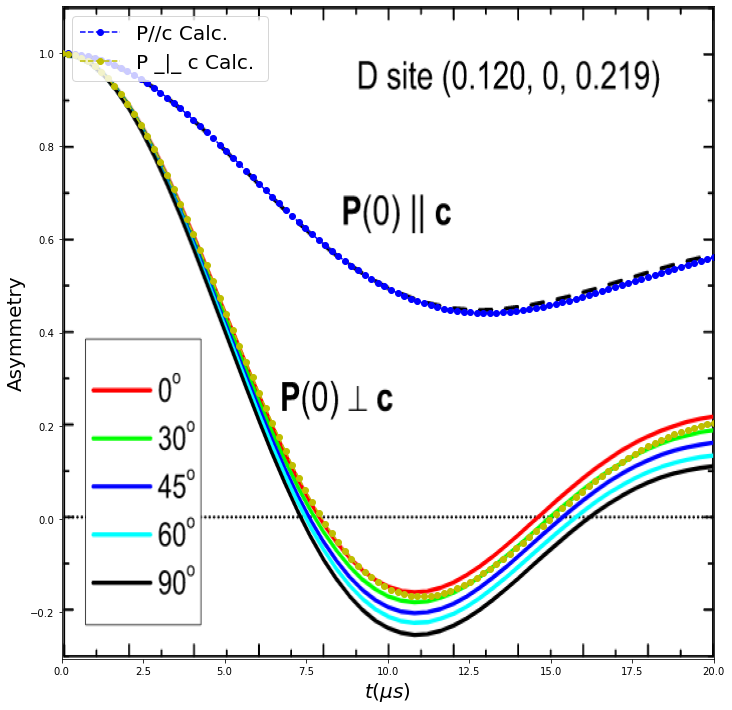

In [5]:
ttime=20
steps = 100
tlist = np.linspace(0, ttime*1e-6, steps)

atoms = gen_neighbouring_atomic_structure([0.12,  0.,  0.219], cutoffs={'Cu': 3.2, 'La': 3.2})

signal_D_Pa = gen_signal(atoms, np.array([1.,0.,0.]))
signal_D_Pc = gen_signal(atoms, np.array([0.,0.,1.]))

fig, axes = plt.subplots(1,1, figsize=(12,12))
axes.plot(tlist*1e6,signal_D_Pc,'b--',marker='o',label='P//c Calc. ', zorder=1)
axes.plot(tlist*1e6,signal_D_Pa,'y--',marker='o',label='P _|_ c Calc. ', zorder=2)

imdata = plt.imread('images/Fig6.png')
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.1], aspect=20/(1.1+0.3), resample=True)

axes.set_ylim([-0.3,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("D.png")
plt.show()

### Site M

Adding atom  Cu  with position [-1.88965e-10  0.00000e+00 -1.26720e-10]  and distance  2.2752083338674725e-10
Adding atom  La  with position [0.00000e+00 1.88965e-10 5.68920e-11]  and distance  1.9734353520954265e-10
Adding atom  Cu  with position [ 1.88965e-10  0.00000e+00 -1.26720e-10]  and distance  2.2752083338674725e-10
Adding atom  La  with position [ 0.00000e+00 -1.88965e-10  5.68920e-11]  and distance  1.9734353520954265e-10
Computing signal...

/usr/lib/python3.8/site-packages/ase/io/cif.py:372: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(139, setting=1). This may result in wrong setting!
  warnings.warn(
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 2048 dimensional


Computing signal...

INFO:undi:Adding interaction between mu and Cu with distance 2.2752083338674723e-10
INFO:undi:Adding interaction between mu and La with distance 1.9734353520954265e-10
INFO:undi:Adding interaction between mu and Cu with distance 2.2752083338674723e-10
INFO:undi:Adding interaction between mu and La with distance 1.9734353520954265e-10


done!
done!


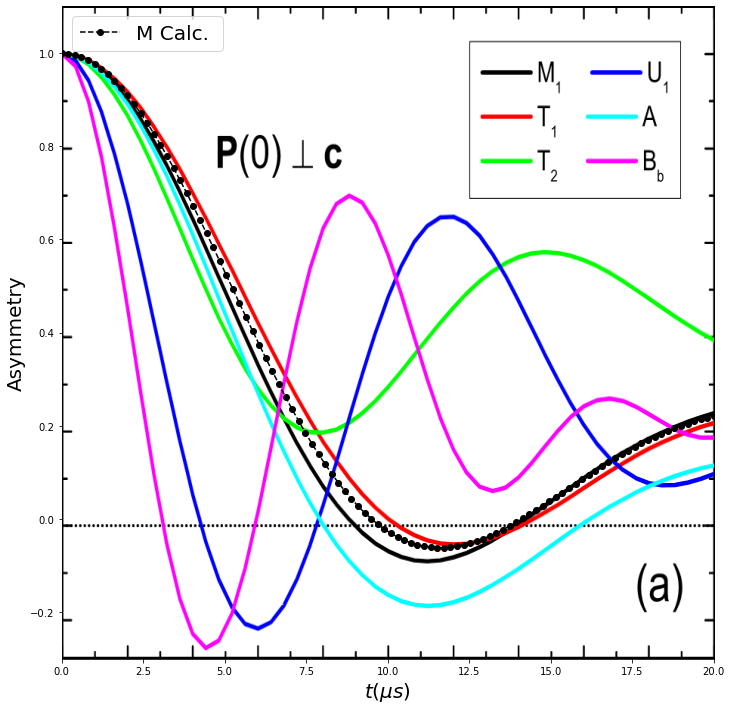

In [6]:
atoms = gen_neighbouring_atomic_structure([0.5,  0.,  0.096], cutoffs={'Cu':3.2, 'La':3.2})

print("Computing signal...", end='', flush=True)
signal_M_Pab = gen_signal(atoms, np.array([1.,1.,0.]))
print('done!')


imdata = plt.imread('images/Fig5a.png')

fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.plot(tlist*1e6,signal_M_Pab,'k--',marker='o',label='M Calc. ', zorder=1)
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.1], aspect=20/(1.1+0.3), resample=True)


axes.set_ylim([-0.3,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("M.png")
plt.show()

### Site T1 and T2

Adding atom  Cu  with position [-7.5586e-11  0.0000e+00 -1.9800e-10]  and distance  2.1193688540695316e-10
Adding atom  La  with position [ 1.13379e-10  1.88965e-10 -1.43880e-11]  and distance  2.2083836489613844e-10
Adding atom  La  with position [-7.55860e-11  0.00000e+00  2.78388e-10]  and distance  2.8846684721125224e-10
Adding atom  Cu  with position [ 3.02344e-10  0.00000e+00 -1.98000e-10]  and distance  3.614082101115026e-10
Adding atom  La  with position [ 1.13379e-10 -1.88965e-10 -1.43880e-11]  and distance  2.2083836489613844e-10
Computing signal...

/usr/lib/python3.8/site-packages/ase/io/cif.py:372: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(139, setting=1). This may result in wrong setting!
  warnings.warn(
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 16384 dimensional


Computing signal...

INFO:undi:Adding interaction between mu and Cu with distance 2.1193688540695316e-10
INFO:undi:Adding interaction between mu and La with distance 2.2083836489613844e-10
INFO:undi:Adding interaction between mu and La with distance 2.884668472112522e-10
INFO:undi:Adding interaction between mu and Cu with distance 3.6140821011150253e-10
INFO:undi:Adding interaction between mu and La with distance 2.2083836489613844e-10


done!
done!
Adding atom  Cu  with position [-8.503425e-11  0.000000e+00 -2.970000e-10]  and distance  3.0893336445431483e-10
Adding atom  La  with position [ 1.0393075e-10  1.8896500e-10 -1.1338800e-10]  and distance  2.4365182241174085e-10
Adding atom  La  with position [-8.503425e-11  0.000000e+00  1.793880e-10]  and distance  1.985217323545774e-10
Adding atom  Cu  with position [ 2.9289575e-10  0.0000000e+00 -2.9700000e-10]  and distance  4.1712938084971013e-10
Adding atom  La  with position [ 1.0393075e-10 -1.8896500e-10 -1.1338800e-10]  and distance  2.4365182241174085e-10
Computing signal...

INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 16384 dimensional


Computing signal...

INFO:undi:Adding interaction between mu and Cu with distance 3.089333644543148e-10
INFO:undi:Adding interaction between mu and La with distance 2.436518224117408e-10
INFO:undi:Adding interaction between mu and La with distance 1.9852173235457738e-10
INFO:undi:Adding interaction between mu and Cu with distance 4.1712938084971013e-10
INFO:undi:Adding interaction between mu and La with distance 2.436518224117408e-10


done!
done!


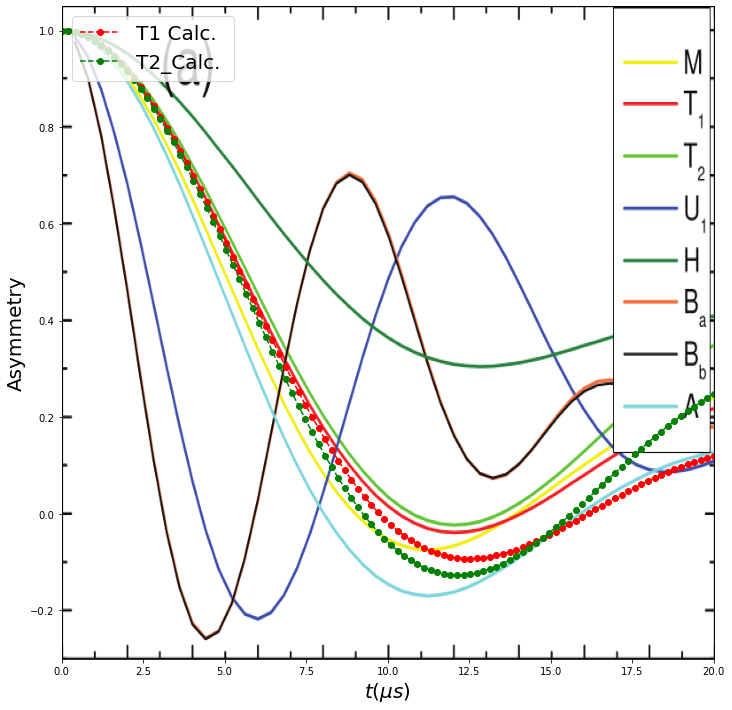

In [7]:
atoms = gen_neighbouring_atomic_structure([0.2,  0.,  0.15], cutoffs={'Cu':4., 'La':3.}) 

print("Computing signal...", end='', flush=True)
signal_T1_Pab = gen_signal(atoms, np.array([1.,1.,0.]), k=4)
print('done!')

atoms = gen_neighbouring_atomic_structure([0.225,  0.,  0.225], cutoffs={'Cu':4.2, 'La':3.}) 

print("Computing signal...", end='', flush=True)
signal_T2_Pab = gen_signal(atoms, np.array([1.,1.,0.]), k=4)
print('done!')



fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.plot(tlist*1e6,signal_T1_Pab,'r--',marker='o',label='T1 Calc. ', zorder=1)
axes.plot(tlist*1e6,signal_T2_Pab,'g--',marker='o',label='T2_Calc. ', zorder=2)

imdata = plt.imread('images/Fig1.png')
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.05], aspect=20/(1.05+0.3), resample=True)


axes.set_ylim([-0.3,1.05])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("T1_and_T2.png")
plt.show()

### Site Ba (not really)

Adding atom  La  with position [-2.26758e-10  1.88965e-10  5.16120e-11]  and distance  2.996510642947894e-10
Adding atom  Cu  with position [-3.7793e-11  0.0000e+00 -1.3200e-10]  and distance  1.3730371753525105e-10
Adding atom  La  with position [1.51172e-10 1.88965e-10 5.16120e-11]  and distance  2.474359378768573e-10
Adding atom  La  with position [-2.26758e-10 -1.88965e-10  5.16120e-11]  and distance  2.996510642947894e-10
Adding atom  La  with position [ 1.51172e-10 -1.88965e-10  5.16120e-11]  and distance  2.474359378768573e-10
Computing signal...

/usr/lib/python3.8/site-packages/ase/io/cif.py:372: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(139, setting=1). This may result in wrong setting!
  warnings.warn(
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 32768 dimensional


Computing signal...

INFO:undi:Adding interaction between mu and La with distance 2.9965106429478937e-10
INFO:undi:Adding interaction between mu and Cu with distance 1.3730371753525102e-10
INFO:undi:Adding interaction between mu and La with distance 2.474359378768573e-10
INFO:undi:Adding interaction between mu and La with distance 2.9965106429478937e-10
INFO:undi:Adding interaction between mu and La with distance 2.474359378768573e-10


done!
done!


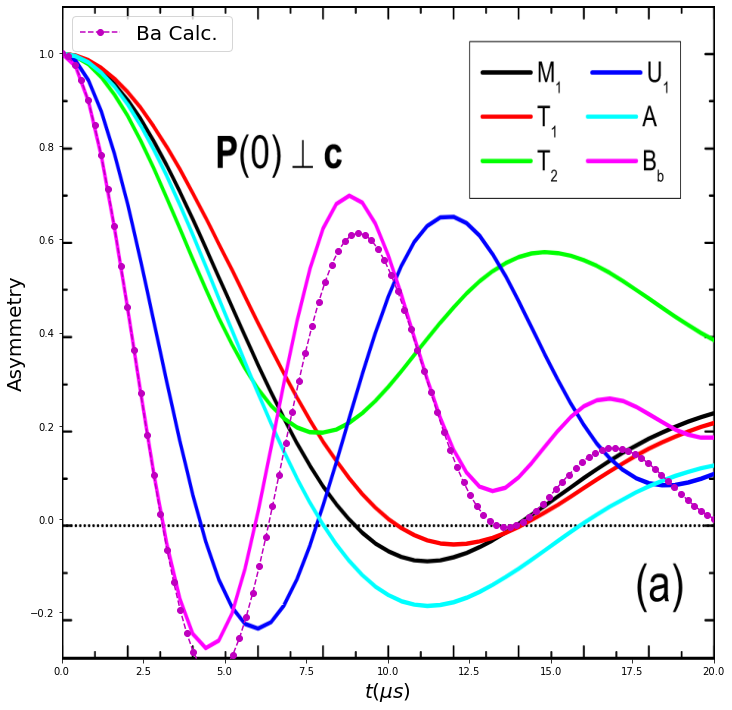

In [8]:
atoms = gen_neighbouring_atomic_structure([0.1,  0.,  0.1], cutoffs={'Cu':2., 'La':3.}) 

print("Computing signal...", end='', flush=True)
signal_Ba_Pab = gen_signal(atoms, np.array([1.,1.,0.]))
print('done!')

imdata = plt.imread('images/Fig5a.png')

fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.plot(tlist*1e6,signal_Ba_Pab,'m--',marker='o',label='Ba Calc. ', zorder=1)
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.1], aspect=20/(1.1+0.3), resample=True)


axes.set_ylim([-0.3,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("Ba.png")
plt.show()

### Site U1 (not really)

Adding atom  Cu  with position [-4.53516e-11  0.00000e+00 -1.45200e-10]  and distance  1.521177426290569e-10
Adding atom  La  with position [1.436134e-10 1.889650e-10 3.841200e-11]  and distance  2.4043307099598423e-10
Adding atom  Cu  with position [ 3.325784e-10  0.000000e+00 -1.452000e-10]  and distance  3.6289314149837554e-10
Adding atom  La  with position [ 1.436134e-10 -1.889650e-10  3.841200e-11]  and distance  2.4043307099598423e-10
Computing signal...

/usr/lib/python3.8/site-packages/ase/io/cif.py:372: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(139, setting=1). This may result in wrong setting!
  warnings.warn(
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 2048 dimensional


Computing signal...

INFO:undi:Adding interaction between mu and Cu with distance 1.521177426290569e-10
INFO:undi:Adding interaction between mu and La with distance 2.4043307099598423e-10
INFO:undi:Adding interaction between mu and Cu with distance 3.628931414983755e-10
INFO:undi:Adding interaction between mu and La with distance 2.4043307099598423e-10
INFO:undi:Adding interaction between mu and Cu with distance 1.521177426290569e-10
INFO:undi:Adding interaction between mu and La with distance 2.4043307099598423e-10
INFO:undi:Adding interaction between mu and Cu with distance 3.628931414983755e-10
INFO:undi:Adding interaction between mu and La with distance 2.4043307099598423e-10
INFO:undi:Adding interaction between mu and Cu with distance 1.521177426290569e-10
INFO:undi:Adding interaction between mu and La with distance 2.4043307099598423e-10
INFO:undi:Adding interaction between mu and Cu with distance 3.628931414983755e-10
INFO:undi:Adding interaction between mu and La with distance 2.4043307099598423e-1

done!
done!


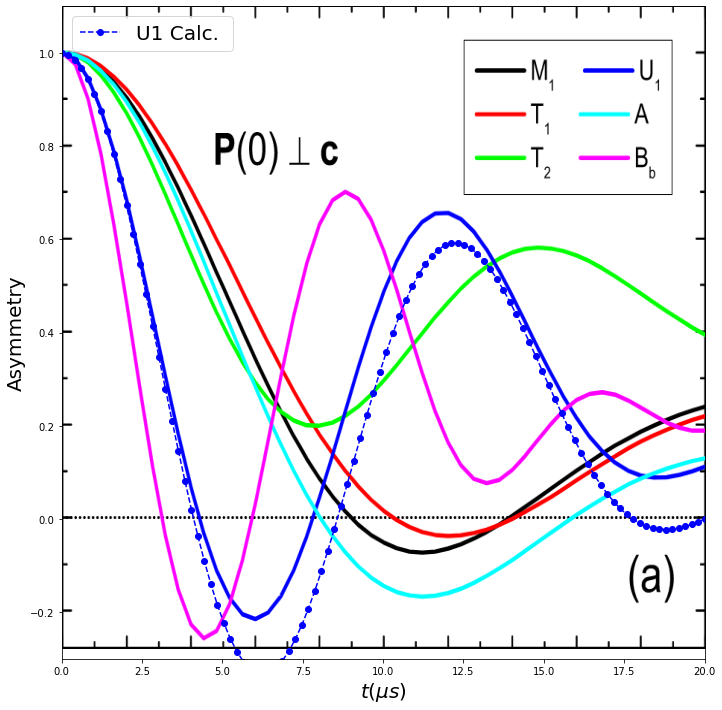

In [9]:
atoms = gen_neighbouring_atomic_structure([0.12,  0.,  0.11], cutoffs={'Cu':3.7, 'La':3.})

print("Computing signal...", end='', flush=True)
signal_U1_Pab = gen_signal(atoms, np.array([1.,1.,0.]), nrep=4, k=4)
print('done!')

imdata = plt.imread('images/Fig5a.png')

fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.plot(tlist*1e6,signal_U1_Pab,'b--',marker='o',label='U1 Calc. ', zorder=1)
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.28, 1.1], aspect=20/(1.1+0.28), resample=True)


axes.set_ylim([-0.3,1.1])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);


plt.legend(loc=2, fontsize=20)
plt.savefig("U1.png")
plt.show()

### Site H

Adding atom  La  with position [-2.8458129e-10  1.8896500e-10 -1.7028000e-11]  and distance  3.4202958150876963e-10
Adding atom  Cu  with position [-9.561629e-11  0.000000e+00 -2.006400e-10]  and distance  2.222585982889393e-10
Adding atom  La  with position [ 9.334871e-11  1.889650e-10 -1.702800e-11]  and distance  2.1145142626065235e-10
Adding atom  La  with position [-9.561629e-11  0.000000e+00  2.757480e-10]  and distance  2.918551599978387e-10
Adding atom  Cu  with position [ 2.8231371e-10  0.0000000e+00 -2.0064000e-10]  and distance  3.463487266527251e-10
Adding atom  La  with position [-2.8458129e-10 -1.8896500e-10 -1.7028000e-11]  and distance  3.4202958150876963e-10
Adding atom  La  with position [ 9.334871e-11 -1.889650e-10 -1.702800e-11]  and distance  2.1145142626065235e-10
Computing signal...

/usr/lib/python3.8/site-packages/ase/io/cif.py:372: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(139, setting=1). This may result in wrong setting!
  warnings.warn(
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is 1048576 dimensional


Computing signal...

INFO:undi:Adding interaction between mu and La with distance 3.420295815087697e-10
INFO:undi:Adding interaction between mu and Cu with distance 2.222585982889393e-10
INFO:undi:Adding interaction between mu and La with distance 2.1145142626065233e-10
INFO:undi:Adding interaction between mu and La with distance 2.918551599978387e-10
INFO:undi:Adding interaction between mu and Cu with distance 3.463487266527251e-10
INFO:undi:Adding interaction between mu and La with distance 3.4202958150876963e-10
INFO:undi:Adding interaction between mu and La with distance 2.1145142626065238e-10
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Using most abundand isotope for La, i.e. 139La, 0.9991119 abundance
INFO:undi:Hilbert space is

done!
Computing signal...

INFO:undi:Adding interaction between mu and La with distance 3.4202958150876963e-10
INFO:undi:Adding interaction between mu and Cu with distance 2.222585982889393e-10
INFO:undi:Adding interaction between mu and La with distance 2.1145142626065235e-10
INFO:undi:Adding interaction between mu and La with distance 2.918551599978387e-10
INFO:undi:Adding interaction between mu and Cu with distance 3.463487266527251e-10
INFO:undi:Adding interaction between mu and La with distance 3.4202958150876963e-10
INFO:undi:Adding interaction between mu and La with distance 2.1145142626065235e-10


done!
done!


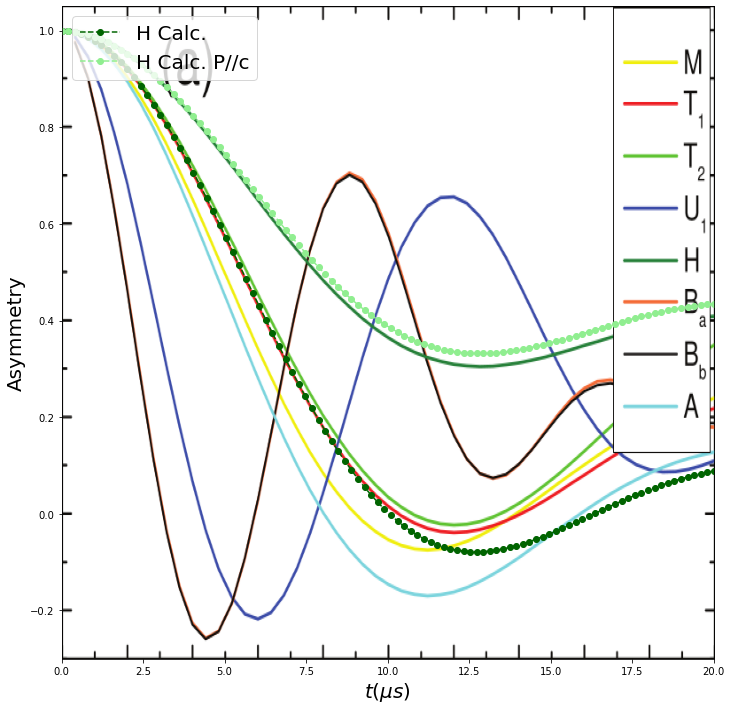

In [10]:
atoms = gen_neighbouring_atomic_structure([0.253,  0.,  0.152], cutoffs={'Cu':4., 'La':3.5}) 

print("Computing signal...", end='', flush=True)
signal_H_Pab = gen_signal(atoms, np.array([1.,1.,0.]), k=1)
signal_H_Pc = gen_signal(atoms, np.array([0.,0.,1.]), k=1)
print('done!')

fig, axes = plt.subplots(1,1, figsize=(12,12))

axes.plot(tlist*1e6,signal_H_Pab,'--', color='darkgreen', marker='o',label='H Calc. ', zorder=1)
axes.plot(tlist*1e6,signal_H_Pc, '--', color='lightgreen', marker='o',label='H Calc. P//c', zorder=2)

imdata = plt.imread('images/Fig1.png')
axes.imshow(imdata, zorder=0, extent=[0., 20.0, -0.3, 1.05], aspect=20/(1.05+0.3), resample=True)


axes.set_ylim([-0.3,1.05])
axes.set_xlim([0,20])
axes.set_xlabel(r'$t (\mu s)$', fontsize=20)
axes.set_ylabel(r'Asymmetry', fontsize=20);

plt.legend(loc=2, fontsize=20)
plt.savefig("H.png")
plt.show()